In [19]:
import networkx as nx
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram

import numpy as np
from scipy.optimize import minimize

In [20]:
# dij需求i到设施j的成本
d = [[1, 2], [1, 2]]
n = 2   # 两个设施点
m = 2   # 两个需求点
# d = [[1, 2], [3, 4], [5, 6]]
# n = 2   # 两个设施点
# m = 3   # 三个需求点
num_qubits = n + 2 * n * m

# gi设施i的建设成本
g = [2, 1]


In [21]:
penalty = 25
depth = 6
params = np.ones(depth * 2)

In [22]:
# dtype=np.complex128
def add_in_target(num_qubits, target_qubit, gate=np.array([[1, 0],[0, -1]])):
    H = np.eye(2 ** (target_qubit))
    H = np.kron(H, gate)
    H = np.kron(H, np.eye(2 ** (num_qubits - 1 - target_qubit)))
    return H


def generate_Hp(n, m, d, g):
    # 初始化 Hp 矩阵为零矩阵
    # print(num_qubits)
    Hp = np.zeros((2**num_qubits, 2**num_qubits))
    for i in range(m):
        for j in range(n):
            Hp += d[i][j] * (add_in_target(num_qubits, n * (1 + i) + j) - np.eye(2**num_qubits)) / 2
    
    for j in range(n):
        Hp +=  g[j - 1] * (add_in_target(num_qubits, j)- np.eye(2**num_qubits)) / 2

    for i in range(m):
        Ht = np.zeros((2**num_qubits, 2**num_qubits))
        for j in range(n):
            Ht += (np.eye(2**num_qubits) - add_in_target(num_qubits, n * (1 + i) + j)) / 2
        Ht -= np.eye(2**num_qubits)
        Hp += -penalty * Ht @ Ht
    
    for i in range(m):
        for j in range(n):
            Ht = (np.eye(2**num_qubits) - add_in_target(num_qubits, n * (1 + i) + j)) / 2 + (np.eye(2**num_qubits) - add_in_target(num_qubits, n * (1 + m + i) + j)) / 2 + (np.eye(2**num_qubits) - add_in_target(num_qubits, j)) / 2
            Hp += -penalty * Ht @ Ht

    return Hp

In [23]:
from scipy.linalg import expm
def build_circ(n, m, d, g, params):
  qc = QuantumCircuit(num_qubits)
  beta = params[:depth + 1]
  gamma = params[depth:]
  for i in range(num_qubits):
    qc.h(i)
  for dp in range(depth):
    qc.unitary(expm(-1j * gamma[dp] * generate_Hp(n, m, d, g)), range(num_qubits))
    for i in range(num_qubits):
      qc.rx(beta[dp], i)
  qc.measure_all()
  return qc

In [24]:
def cost_function(x):
  num = [int(char) for char in x]
  num = num[::-1]
  C = 0
  for i in range(m):
    for j in range(n):
      C += d[i][j] * num[n * (1 + i) + j]
      
  for j in range(n):
    C += g[j] * num[j]

  for i in range(m):
    t = 0
    for j in range(n):
      t += num[n * (1 + i) + j]
    C += penalty * (t - 1)**2

  for i in range(m):
    for j in range(n):
      C += penalty * (num[n * (1 + i) + j] + num[n * (1 + m + i) + j] - num[j]) ** 2
  return C

def compute_expectation(counts):
  EV = 0
  total_count = 0
  for x, count in counts.items():
    C = cost_function(x)
    EV += C*count
    total_count += count

  return EV/total_count


def expectation_from_sample(shots = 2000):
  backend = Aer.get_backend('qasm_simulator')
  backend.shots = shots

  def execute_circ(theta):
    qc = build_circ(n, m, d, g, theta)
    counts = backend.run(qc, seed_simulator=10, shots=shots).result().get_counts()
    return compute_expectation(counts)
  
  return execute_circ

In [25]:
from scipy.optimize import minimize
import numpy as np

expectation = expectation_from_sample()

def callback(x):
    global iteration_count
    iteration_count += 1
    if iteration_count % 10 == 0:
        print(f"Iteration {iteration_count}, Result: {expectation(x)}")

# 设定最大迭代次数
max_iterations = 1000

# 初始化迭代计数器
iteration_count = 0

# 使用 COBYLA 方法进行最小化，并设置 callback 函数
res = minimize(expectation, params, method='COBYLA', options={'maxiter': max_iterations}, callback=callback)

# 输出最终结果
print("Final Result:", res)

Iteration 10, Result: 51.2275
Iteration 20, Result: 51.2275
Iteration 30, Result: 51.2275
Iteration 40, Result: 51.2275
Iteration 50, Result: 51.2275
Iteration 60, Result: 51.2275
Iteration 70, Result: 51.2275
Final Result:  message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 51.2275
       x: [ 1.000e+00  1.000e+00  1.000e+00  1.000e+00  1.000e+00
            1.000e+00  1.000e+00  1.000e+00  1.000e+00  1.000e+00
            1.000e+00  1.000e+00]
    nfev: 73
   maxcv: 0.0


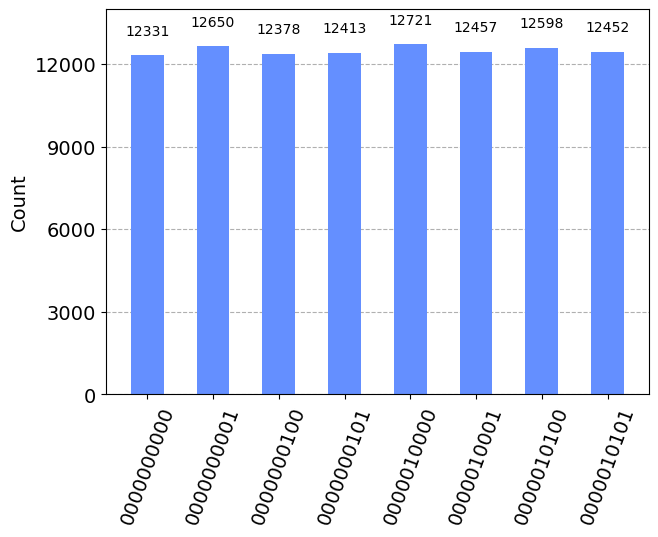

In [26]:
from numpy.lib.utils import source
backend = Aer.get_backend('aer_simulator')
backend.shots = 100000

shots=100000
qc_res = build_circ(n, m, d, g, params=res.x)

counts = backend.run(qc_res, seed_simulator=10, shots = shots).result().get_counts()
plot_histogram(counts)

In [27]:
sorted_counts = sorted(counts, key=counts.get, reverse=True)
print("\n----------------- Full result ---------------------")
print("selection\t\tprobability\tvalue")
print("---------------------------------------------------")
for x in sorted_counts[:20]:
  print(x, "{:.1f}%".format(counts[x] / shots * 100), cost_function(x))


----------------- Full result ---------------------
selection		probability	value
---------------------------------------------------
0000010000 12.7% 51
0000000001 12.7% 102
0000010100 12.6% 52
0000010001 12.5% 53
0000010101 12.5% 4
0000000101 12.4% 53
0000000100 12.4% 51
0000000000 12.3% 50
